In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers
import cvxopt
cvxopt.solvers.options['show_progress'] = False

##**Class SVM**

In [4]:
class SVM:
    def __init__(self,kernel='linear',C=10,sigma=0.1):
        self.kernel = kernel
        self.C = C
        self.sigma = sigma

    def K(self,x1,x2):

        if self.kernel == 'linear':
            return np.dot(x1,x2)

        if self.kernel == 'poly':
            return (1+np.dot(x1,x2))**2

        if self.kernel == 'rbf':
            sigma_sq = self.sigma**2
            gama = 0.5/sigma_sq
            norm_sq = np.linalg.norm(x1-x2)**2
            val = np.exp(-gama*norm_sq)
            return val

    def solve_dual_cvxopt(self):

        n,m = self.x.shape
        K_mat = np.zeros((n,n))

        for i in range(n):
            for j in range(n):
                K_mat[i,j] = self.K(self.x[i],self.x[j])

        P = matrix(np.outer(self.y,self.y)*K_mat)
        q = matrix(-np.ones(n))
        G = matrix(np.vstack((-np.eye(n), np.eye(n))))
        h = matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))
        A = matrix(self.y,(1,n))
        A = cvxopt.matrix(A, (1, n), 'd')
        b = matrix(0.0)

        soln = solvers.qp(P, q, G, h, A, b)

        return np.array(soln['x']).reshape((-1,1))


    def fit(self,x,y):
        self.x = x
        self.y = y
        alphas = self.solve_dual_cvxopt()
        self.alphas = alphas

        support_vec = []
        for i in range(x.shape[0]):
            if alphas[i] > 0.0001:
                support_vec.append(i)
        self.support_vectors = support_vec


        b_vals = []
        for v in self.support_vectors:
            sum = 0
            for u in self.support_vectors:
                sum += self.alphas[u]*y[u]*self.K(x[v],x[u])
            b_vals.append(y[v]-sum)
        self.b = np.mean(b_vals)

        A = self.alphas.reshape((-1,1))
        Y = self.y.reshape((-1,1))
        X = self.x
        w = np.sum(A*Y*X,axis=0)
        margin_ = 1/np.linalg.norm(w)
        self.margin = margin_


    def predict(self,x1):
        y_predicted = []
        for val in x1:
            sum_ = 0
            for vec in self.support_vectors:
                sum_ += self.alphas[vec]*self.y[vec]*self.K(self.x[vec],val)
            y_predicted.append(np.sign(sum_+self.b))

        return np.array(y_predicted)

    def score(self,x1,y):
        y1 = self.predict(x1)
        correct_pred = np.sum(y1.reshape((-1,1)) == y.reshape((-1,1)))
        accuracy = 100*correct_pred/(x1.shape[0])
        return accuracy

    def num_misclassification(self,x1,y):
        y1 = self.predict(x1)
        return np.sum(y1.reshape((-1,1)) != y.reshape((-1,1)))

    def plot_contour_boundary(self,df,p=50):

        max_gate = np.max(df.iloc[:,0].values)
        min_gate = np.min(df.iloc[:,0].values)

        max_ugc = np.max(df.iloc[:,1].values)
        min_ugc = np.min(df.iloc[:,1].values)

        gate = np.linspace(min_gate-0.1,max_gate+0.1,p)
        ugc = np.linspace(min_ugc-0.1,max_ugc+0.1,p)

        gate,ugc = np.meshgrid(gate,ugc)

        z = np.zeros(gate.shape)
        for i in range(z.shape[0]):
            for j in range(z.shape[1]):
                x_mesh = np.array([gate[i][j],ugc[i][j]]).reshape((-1,2))
                z[i][j] = self.predict(x_mesh)

        cm = ListedColormap(['y','m'])
        plt.contourf(gate,ugc,z,cmap=cm)
        sns.scatterplot(data=df,x='GATE',y='UGC',hue='Label',palette=['r','b'])



##**Linear SVM**

**Load and Plot Data (SVM_data1.csv)**

In [5]:
df_svm1 = pd.read_csv('https://raw.githubusercontent.com/Niraj-243/ML-datasets/main/NIRAJ%20KUMAR%20-%20SVM_data1.csv')
df_svm1.head()

,GATE,UGC,Label
0,1.9643,4.5957,1
1,2.2753,3.8589,1
2,2.9781,4.5651,1
3,2.9320,3.5519,1
4,3.5772,2.8560,1


<Axes: xlabel='GATE', ylabel='UGC'>

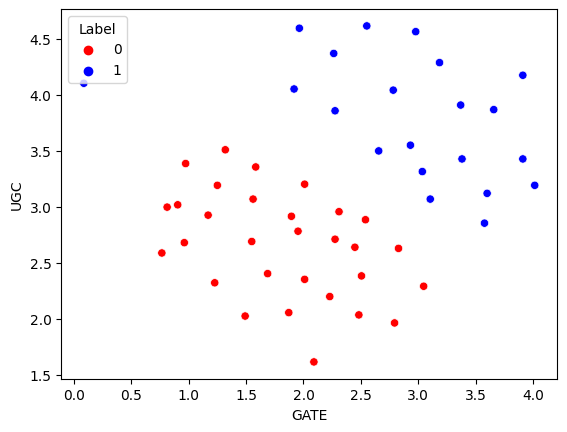

In [6]:
sns.scatterplot(data=df_svm1,x='GATE',y='UGC',hue='Label',palette=['r','b'])

**Linear SVM experiment with C and Plots**

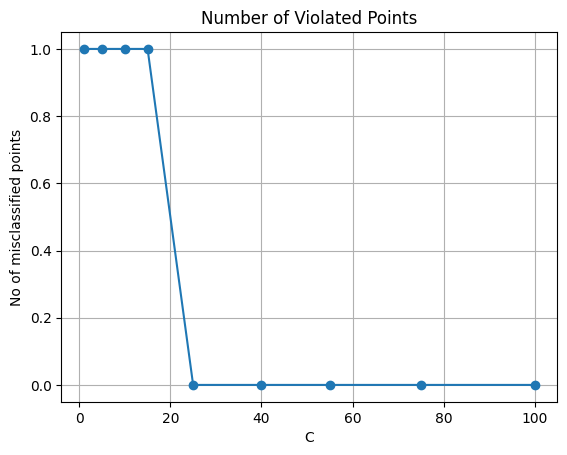

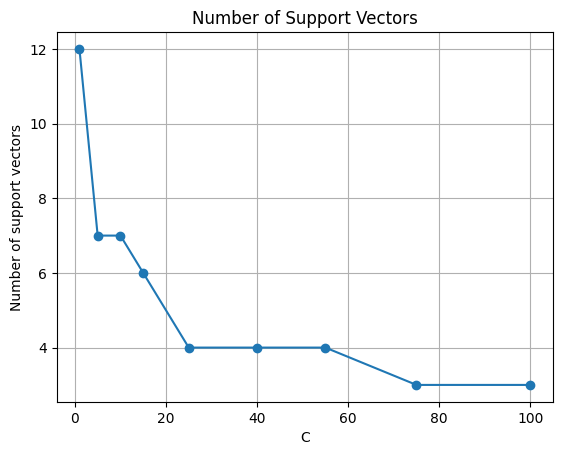

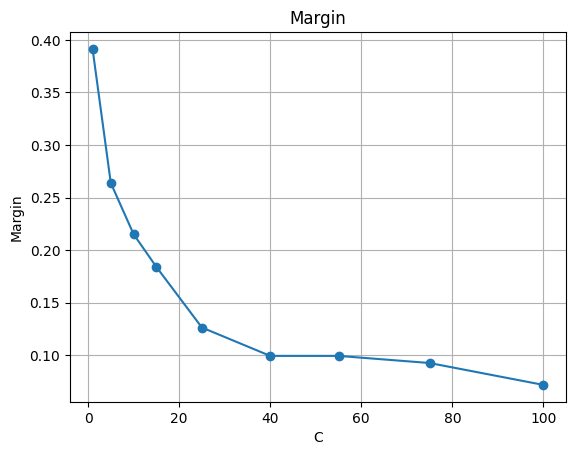

In [7]:
x = df_svm1.iloc[:,:-1].values
y = df_svm1.iloc[:,-1].values

for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1

C = [1,5,10,15,25,40,55,75,100]

sv_list = []
vp_list = []
margin_list = []
for c in C:
    svc = SVM(kernel='linear',C=c)
    svc.fit(x,y)

    num_of_sup_vec = len(svc.support_vectors)
    num_violated_points = svc.num_misclassification(x,y)

    margin_list.append(svc.margin)
    sv_list.append(num_of_sup_vec)
    vp_list.append(num_violated_points)

plt.title('Number of Violated Points')
plt.xlabel('C')
plt.ylabel('No of misclassified points')
plt.plot(C,vp_list,marker='o')
plt.grid()
plt.show()

plt.title('Number of Support Vectors')
plt.xlabel('C')
plt.ylabel('Number of support vectors')
plt.plot(C,sv_list,marker='o')
plt.grid()
plt.show()

plt.title('Margin')
plt.xlabel('C')
plt.ylabel('Margin')
plt.plot(C,margin_list,marker='o')
plt.grid()
plt.show()

From these graphs, it seems that optimal value parameter C is 10 because for greater values<br>
the value of margin will be less, and for smaller values, number of support vectors is high <br>(It is good if support vectors are less) and Accuracies are nearly same.

**Contour Plot for Optimal Linear Classifier**

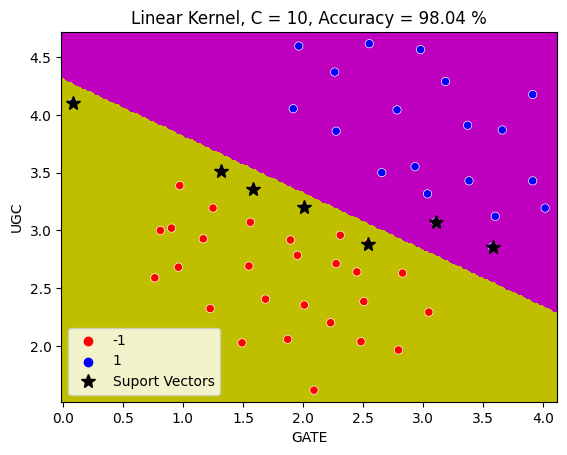

In [8]:
x = df_svm1.iloc[:,:-1].values
y = df_svm1.iloc[:,-1].values

for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1

svc = SVM(kernel='linear',C=10)
svc.fit(x,y)
svc.plot_contour_boundary(df_svm1,p=200)
plt.title('Linear Kernel, C = 10, Accuracy = {} %'.format(np.round(svc.score(x,y),2)))
sv = svc.support_vectors
plt.plot(x[sv][:,0],x[sv][:,1],'k*',ms=10,label='Suport Vectors')
plt.legend()
plt.show()

## **Non Linear SVM**

**Load and Plot Data (SVM_data2.csv)**

In [9]:
# Load Data
df_svm2 = pd.read_csv('https://raw.githubusercontent.com/Niraj-243/ML-datasets/main/NIRAJ%20KUMAR%20-%20SVM_data2.csv')
df_svm2 = df_svm2.rename({'Y label': 'Label'}, axis=1)
df_svm2.head()


,GATE,UGC,Label
0,0.107140,0.60307,1
1,0.093318,0.64985,1
2,0.097926,0.70541,1
3,0.155530,0.78436,1
4,0.210830,0.86623,1


Scatter Plot

<Axes: xlabel='GATE', ylabel='UGC'>

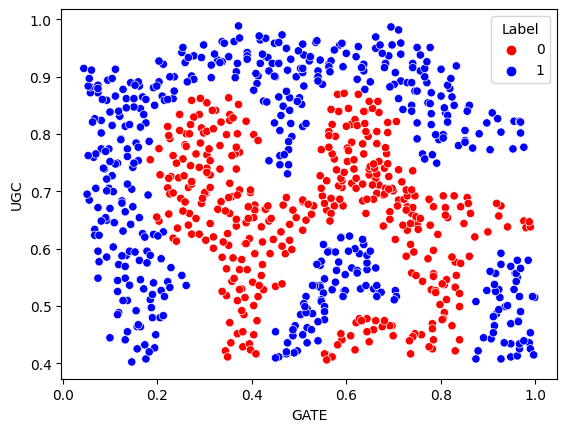

In [10]:
sns.scatterplot(data=df_svm2,x='GATE',y='UGC',hue='Label',palette=['r','b'])

**Polynomial Kernel (degree = 2)**

 Experiment With C

In [11]:
x = df_svm2.iloc[:,:-1].values
y = df_svm2.iloc[:,-1].values

for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1

C = [1,50,1000,1e5]
for c in C:
    svc = SVM(kernel='poly',C=c)
    svc.fit(x,y)
    print('For C = {}, Accuracy = {}'.format(c,svc.score(x,y)))

For C = 1, Accuracy = 71.49478563151796
For C = 50, Accuracy = 79.14252607184241
For C = 1000, Accuracy = 80.76477404403245
For C = 100000.0, Accuracy = 82.73464658169178



From above Cell's accuracy, it seems that C = 50 is good because<br>
accuracy does not increase much on increasing C further. And we prefer smaller C because,<br>
margin decreases with increase in C

**Polynomial Kernel (Contour Plot for Optimal C = 50)**

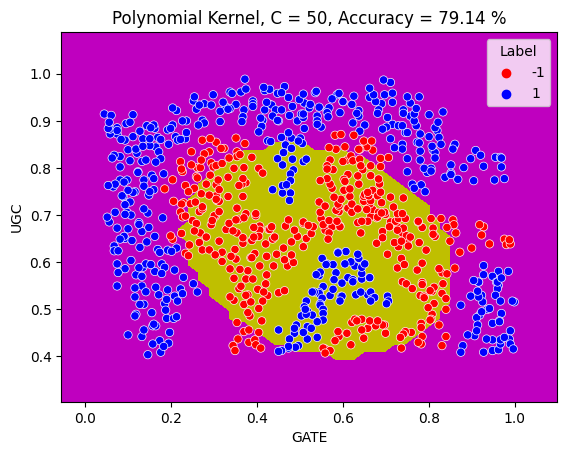

In [12]:
x = df_svm2.iloc[:,:-1].values
y = df_svm2.iloc[:,-1].values

for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1

svc = SVM(kernel='poly',C=50)
svc.fit(x,y)
svc.plot_contour_boundary(df_svm2)
plt.title('Polynomial Kernel, C = 50, Accuracy = {} %'.format(np.round(svc.score(x,y),2)))
plt.show()

**RBF Kernel**

Experiment with C and sigma

For C = 1 : sigma = 0.15 : Accuracy = 95.36500579374275
For C = 20 : sigma = 0.15 : Accuracy = 99.18887601390499
For C = 100 : sigma = 0.15 : Accuracy = 99.30475086906141
For C = 100000.0 : sigma = 0.15 : Accuracy = 100.0


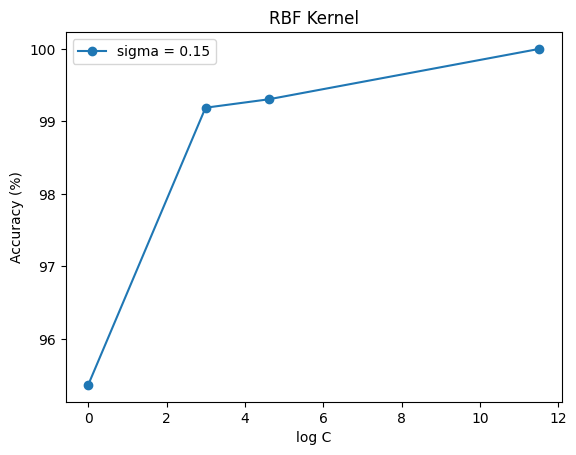

For sigma = 0.0001 : Accuracy = 100.0
For sigma = 0.01 : Accuracy = 100.0
For sigma = 0.2 : Accuracy = 99.88412514484357
For sigma = 0.5 : Accuracy = 93.85863267670915
For sigma = 0.8 : Accuracy = 88.52838933951332


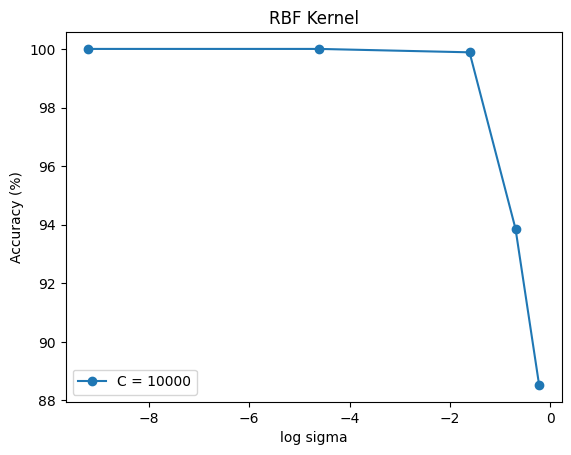

In [13]:
x = df_svm2.iloc[:,:-1].values
y = df_svm2.iloc[:,-1].values

for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1

# Experiment with fixed sigma = 0.15
C = [1,20,100,1e5]
accu_l = []
for c in C:
    svc = SVM(kernel='rbf',C = c,sigma=0.15)
    svc.fit(x,y)
    accu = svc.score(x,y)
    print('For C = {} : sigma = {} : Accuracy = {}'.format(c,0.15,accu))
    accu_l.append(accu)

plt.title('RBF Kernel')
plt.xlabel('log C')
plt.ylabel('Accuracy (%)')
plt.plot(np.log(C),accu_l,marker='o',label='sigma = {}'.format(0.15))
plt.legend()
plt.show()


# Experiment with fixed c = 10000
accu_l = []

sigma = [0.0001,0.01,0.2,0.5,0.8]
for s in sigma:
    svc = SVM(kernel='rbf',C = 10000,sigma=s)
    svc.fit(x,y)
    accu = svc.score(x,y)
    accu_l.append(accu)
    print('For sigma = {} : Accuracy = {}'.format(s,accu))

plt.title('RBF Kernel')
plt.xlabel('log sigma')
plt.ylabel('Accuracy (%)')
plt.plot(np.log(sigma),accu_l,marker='o',label='C = {}'.format(10000))
plt.legend()
plt.show()

**Contour Plot for Optimal RBF Classifier**

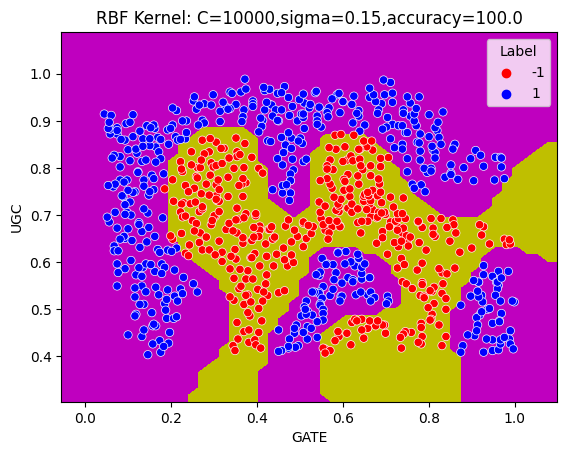

In [14]:
x = df_svm2.iloc[:,:-1].values
y = df_svm2.iloc[:,-1].values

for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1

svc = SVM(kernel='rbf',C = 10000,sigma=0.15)
svc.fit(x,y)
svc.plot_contour_boundary(df_svm2)
accu = svc.score(x,y)
plt.title('RBF Kernel: C={},sigma={},accuracy={}'.format(10000,0.15,accu))
plt.show()